<h1 style="font-weight: bold; text-align:center; margin: 0 0 0 0">Tutorial 1: Introduction to WaveSongs </h1>

<hr styles="width: 70px; padding: 0 0 100px 0;">
<br>

<a target="_blank" href="https://colab.research.google.com/github/wavesongs/wavesongs/blob/main/Tutorial1_Introduction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This tutorial guides users through analyzing, visualizing, and generating synthetic birdsongs using the `wavesongs` Python package, which is based on the motor gestures for birdsongs model developed by [Prof. G. Mindlin](https://scholar.google.com.ar/citations?user=gMzZPngAAAAJ&hl=en).

If you are using Google Colab uncomment and execute the following cell:

In [ ]:
# ! git clone https://github.com/wavesongs/wavesongs
# ! pip install wavesongs

# # enable hird party widgets (ipympl)
# from google.colab import output
# output.enable_custom_widget_manager()

# # correct ProjDirs parameters,
# audios = "/content/wavesongs/assets/audio"
# results = "/content/wavesongs/assets/audio/results"

> **NOTE**: If you encounter an error message, reset the kernel and run the above cell again. After that, everything should work successfully.

Then, follow the [installation guide](https://github.com/wavesongs/wavesongs#%EF%B8%8F-installation) to set up the evironment and install the required libraries.

## Libraries

Import the required classes and functions from `wavesongs`:

In [1]:
# Select matplotlib backend and enable interactive plots
%matplotlib ipympl

from wavesongs.utils.paths import ProjDirs       # Manages project files
from wavesongs.objects.song import Song          # Song objects
from wavesongs.objects.syllable import Syllable  # Syllable objects
from wavesongs.utils import plots                # Plotting utilities
from wavesongs.utils.tools import get_positions  # Data extraction tools

To use objects like `Syllable` or `Song`, first define a project directory using a `ProjDirs` object. This object manages generated files such as images, audio files, and CSVs.

Next, create a `Song` instance with the project directory and a file name. In this tutorial, we use the audio file `574179401 - Zonotrichia Capensis.wav` located at `assets/audio/`.

Once the song is defined, compute its acoustic features. You can specify parameters such as the Fast Fourier Transform (FFT) window and fundamental frequency (FF) method.

To display the spectrogram, use the `plots` module and the `spectrogram_waveform` function.

The name assigned to the song and syllables, "Copetón," is the common name for Zonotrichia capensis in Colombia.

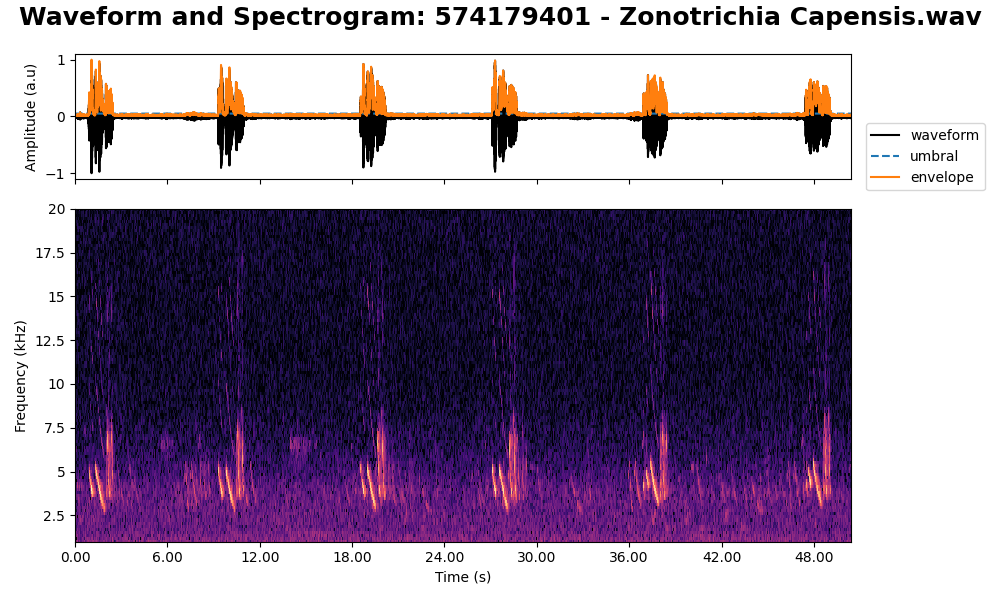

In [2]:
proj_dirs = ProjDirs(audios="./assets/audio", results="./assets/results")

# Define the song and compute its acoustic features
copeton_song = Song(proj_dirs, file_id="574179401")
copeton_song.acoustical_features(umbral_FF=1.4, NN=256)

# Display the song
plots.spectrogram_waveform(copeton_song, save=False)

In [3]:
# Play the song
copeton_song.play()

Long audio files can slow down plot response. A best practice is to define a **region of interest (ROI)**, such as a complete birdsong.

To select a specific time interval, set `select_time=True` and define the start and end of the ROI.

Image save at assets/results/images/574179401 - Zonotrichia Capensis-Song.png


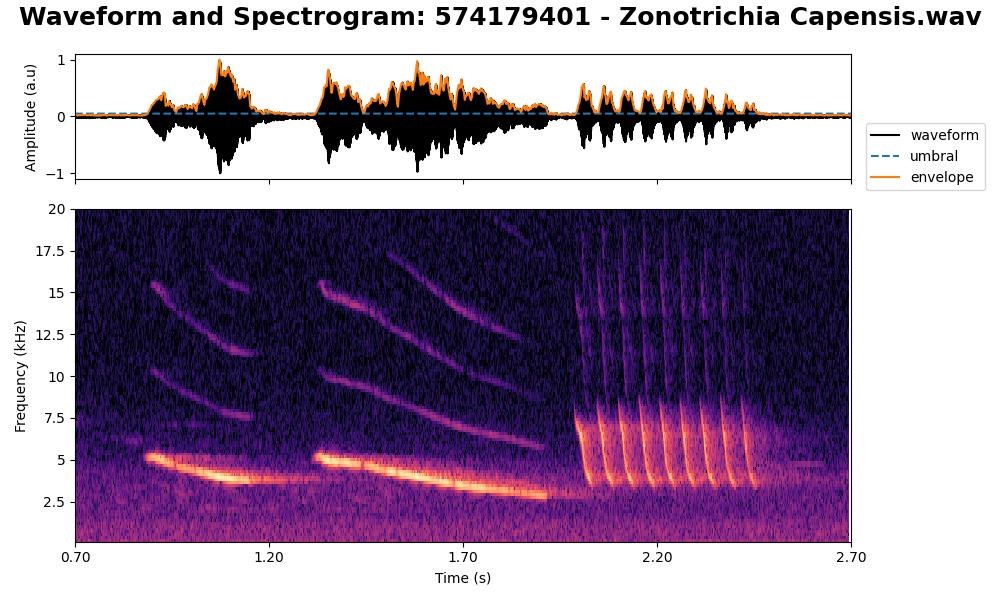

In [4]:
# Define time interval for ROI
tlim_roi = (0.7, 2.7)

copeton_syllable = Song(proj_dirs, file_id="574179401", tlim=tlim_roi)
copeton_syllable.acoustical_features(umbral_FF=1.4, NN=256, ff_method="yin", flim=(1e2, 2e4))

klicker_times = plots.spectrogram_waveform(copeton_syllable, tlim=tlim_roi,
                                           select_time=True, save=True)

In [5]:
copeton_syllable.play()

This function returns an array of measurements, where each element is a vector containing time and frequency range values.

> **WARNING**: If no selection is made, an error will occur.

In [6]:
data = get_positions(klicker_times)
tlim, flim = data[0] # index = 0: first pair
t0 = tlim[0] + copeton_syllable.t0_bs
tend = tlim[1] + copeton_syllable.t0_bs
print(f"Region of Interest: (tini = {t0:.4f} s, tend = {tend:.4f} s)")

Region of Interest: (tini = 0.8881 s, tend = 1.3082 s)


Image save at assets/results/images/574179401-ZonotrichiaCapensis-0-intro-down


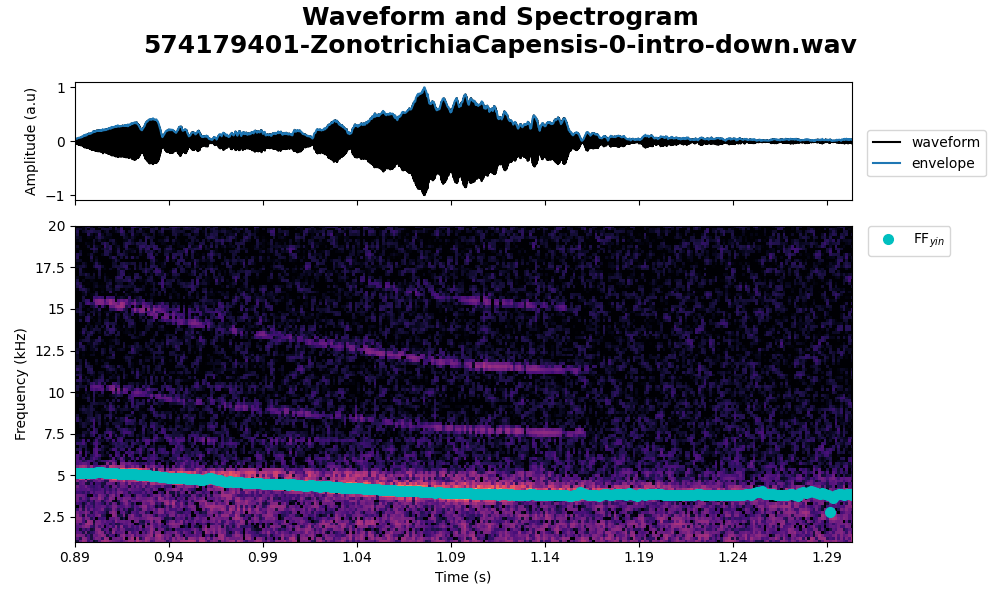

In [7]:
# Define a syllable object within the selected time limits
# tlim = (0.1829-song_copeton.t0_bs, 0.5927-song_copeton.t0_bs)
copeton_syllable_0 = Syllable(obj=copeton_syllable, tlim=tlim, type="intro-down", no_syllable="0")
copeton_syllable_0.acoustical_features(NN=256)

# Display the syllable's spectrogram
plots.spectrogram_waveform(copeton_syllable_0, ff_on=True, save=True)

In [8]:
copeton_syllable_0.play()

## Synthetic Syllable

We can generate a synthetic syllable using the optimizer module, which solves a minimization problem to find the optimal parameters that make the generated song most similar to the real one.

### Optimal Parameters

The birdsong model consists of four constant parameters that define:

  - The air-sac pressure curve:  $\alpha(t) = a_0 $
  - The labial tension:  $\beta(t) = b_0 + b_1 \cdot t + b_2 \cdot t^2$

Both variables change over time, but we are just interested in the coefficients.

In [9]:
from wavesongs.model import optimizer

optimal_z = optimizer.optimal_params(syllable=copeton_syllable_0, Ns=5)
print(f"\nOptimal z values:\n\t{optimal_z}")


Computing a0*...


Optimization terminated successfully.
         Current function value: 0.004753
         Iterations: 1
         Function evaluations: 2
	 Optimal values: a_0=0.0010, t=0.91 min

Computing b0*, b1*, and b2*...
Optimization terminated successfully.
         Current function value: 0.001321
         Iterations: 36
         Function evaluations: 71
	 Optimal values: b_0=-0.2125, b_2=1.2858, t=18.98 min
Optimization terminated successfully.
         Current function value: 0.001321
         Iterations: 10
         Function evaluations: 21
	 Optimal values: b_1=1.0000, t=5.56 min

Time of execution: 25.45 min

Optimal z values:
	{'a0': 0.001, 'b0': -0.21246, 'b1': 1.0, 'b2': 1.2858}


### Solution

Now, we generate and visualize the synthetic syllable using the computed optimal parameters, `optimal_z`.

Image save at assets/results/images/synth_574179401-ZonotrichiaCapensis-0-intro-down


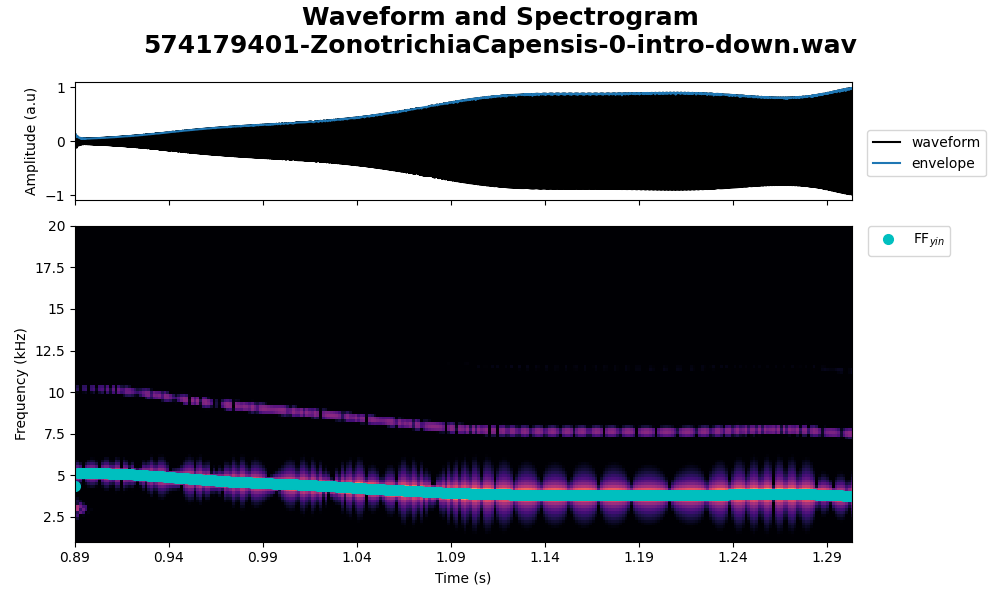

In [10]:
synth_copeton_syllable_0 = copeton_syllable_0.solve(z=optimal_z)
plots.spectrogram_waveform(synth_copeton_syllable_0, ff_on=True, save=True)

In [12]:
synth_copeton_syllable_0.play()

Comparing spectros

Image save at 574179401-ZonotrichiaCapensis-0-intro-down-SoundAndSpectros.png


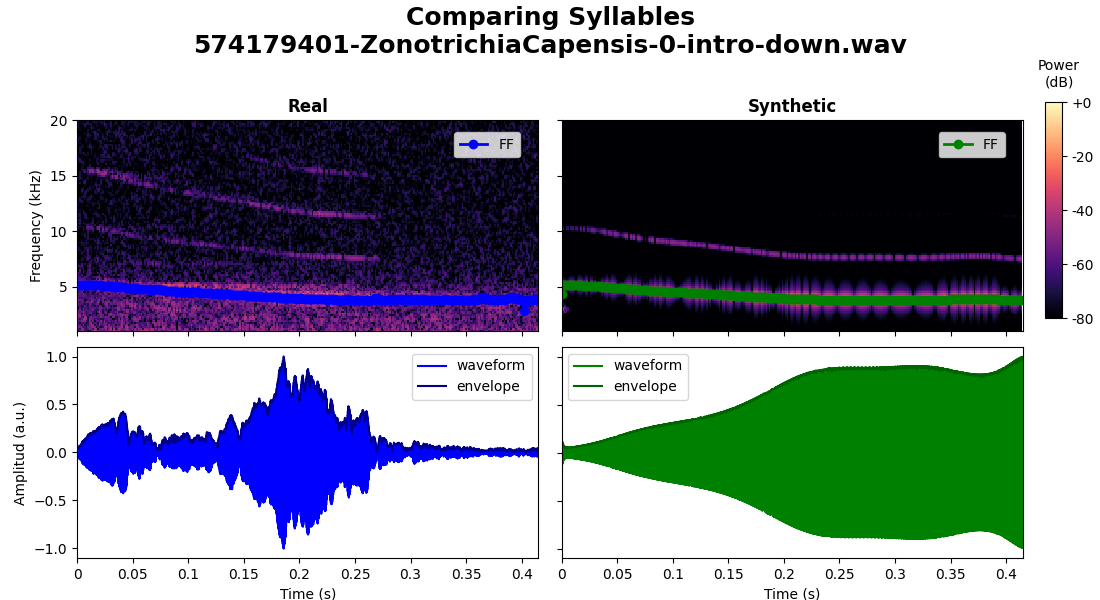

In [13]:
plots.syllables(copeton_syllable_0, synth_copeton_syllable_0, ff_on=True)

### Motor Gesture

Image save at synth_574179401-ZonotrichiaCapensis-0-intro-down-mg_params.png


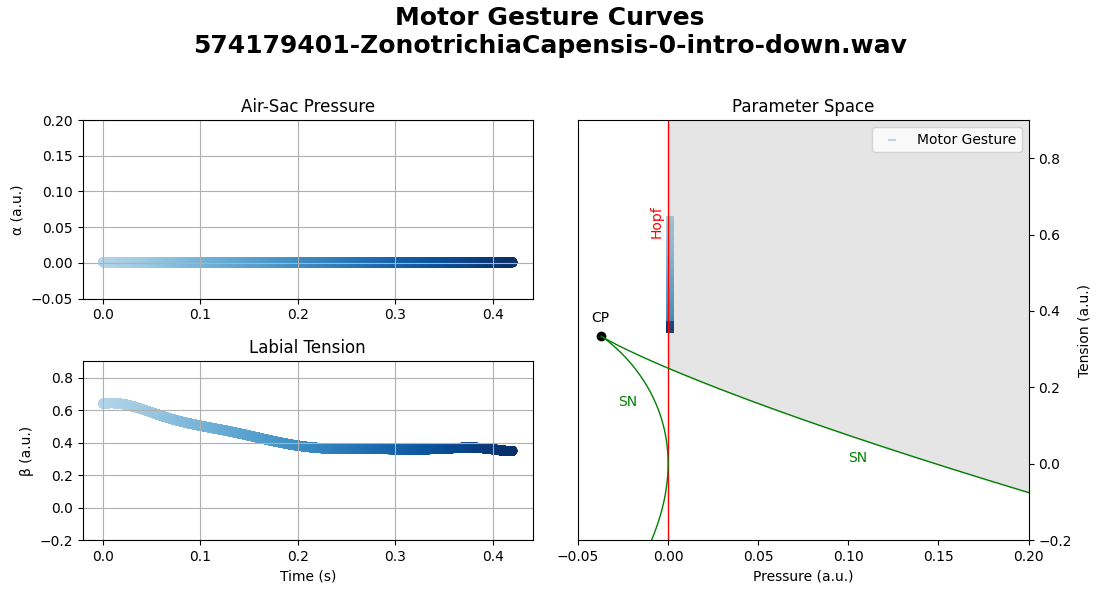

In [14]:
plots.alpha_beta(synth_copeton_syllable_0)

### Model Scores

Image save at 574179401-ZonotrichiaCapensis-0-intro-down-ScoringVariables.png


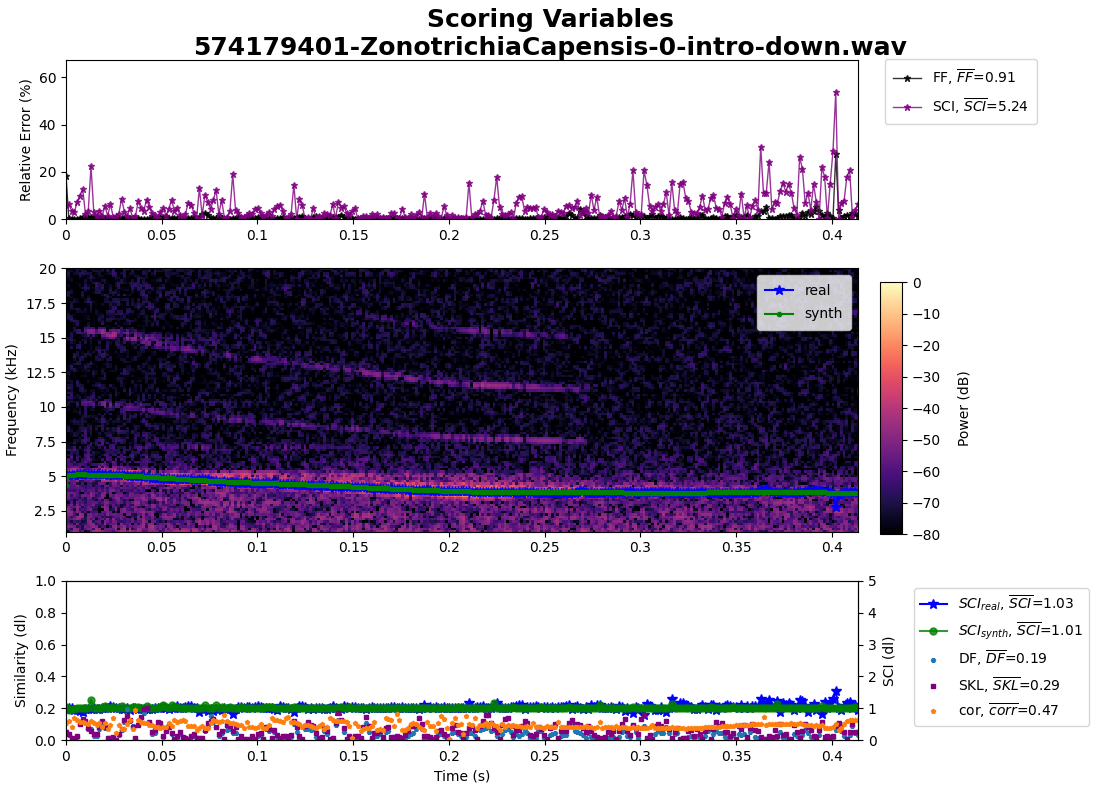

In [15]:
plots.scores(copeton_syllable_0, synth_copeton_syllable_0)

## Further Lectures

For more details on birdsong modeling and bioacoustics, refer to the WaveSongs documentation and related scientific literature.

## Applications

Some fields were we belive this package can contribute:

- Bioacoustic Research
- AI & Machine Learning
- Ecology & Conservation
- Neurobiology & Behavior
- Sound Synthesis & Engineering
- Education & Citizen Science

## Conclusion

This tutorial introduced **WaveSongs** for bioacoustic analysis, covering setup, song processing, spectrogram visualization, and synthetic syllable generation. By following these steps, you can analyze bird vocalizations and optimize synthetic models for research or educational purposes.

Happy coding! 🎵🔬